# scikit-FIBERS: Demonstration Notebook
This notebook is set up as a demonstration for running scikit-FIBERS.

## Installation:

In [1]:
#Add Installation code

## Imports:

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from paretoset import paretoset
from sklearn.metrics import classification_report
from src.skfibers.fibers import FIBERS
from src.skfibers.experiments.datagen import create_data_simulation_bin
from src.skfibers.experiments.datagen_evolvable_threshold import create_data_simulation_bin_evolve

current_working_directory = os.getcwd()
print(current_working_directory)

C:\Users\ryanu\Desktop\scikit-FIBERS


## Survial Data Simulation

In [3]:
data = create_data_simulation_bin_evolve(number_of_instances=10000, number_of_features=100, number_of_features_in_bin=10,
                                  no_fail_proportion=0.5, mm_frequency_range=(0.4, 0.5), noise_frequency=0.0,
                                  class0_time_to_event_range=(1.5, 0.2), class1_time_to_event_range=(1, 0.2),
                                  censoring_frequency=0.5, random_seed=42, negative=False, threshold=0)
data.to_csv('sampledata.csv', index=False)
data = pd.read_csv('sampledata.csv')
true_risk_group = data[['TrueRiskGroup']]
data = data.drop('TrueRiskGroup', axis=1)

## Running FIBERS (Training)

In [4]:
fibers = FIBERS(outcome_label="Duration", outcome_type="survival", iterations=50, pop_size = 50, crossover_prob=0.5, mutation_prob=0.1, 
                new_gen=1.0, elitism=0.1, min_bin_size=1, fitness_metric="log_rank", log_rank_weighting=None,
                censor_label="Censoring", group_strata_min=0.2, group_thresh=None, min_thresh=0, max_thresh=3, int_thresh=True, thresh_evolve_prob=0.5,
                manual_bin_init=None, covariates=None, report=None, random_seed=None, verbose=False)

fibers = fibers.fit(data)

Beginning FIBERS Fit:


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:13<00:00,  1.47s/it]

Random Seed Check - End: 0.22110558498365007
FIBERS Run Complete!
Elapsed Time (sec):  78.44402527809143 seconds


## Top-Bin Examination

In [5]:
bin_index = 0 # lowest index is the bin with the highest fitness (only reports the bin ranked at the top, despite possible fitness ties for top)
# Get bin reportting variables 
low_outcome, high_outcome, low_censor, high_censor, bin_report_df = fibers.get_bin_groups(data, bin_index)
bin_report_df

,0
Features in Bin:,"[P_1, P_10, P_2, P_3, P_5, P_7, P_8]"
Threshold:,0
Fitness:,5497.749569
Metric Score:,5497.67814
p-value:,0.0
Bin Size:,7
Group Ratio:,0.5
Count At/Below Threshold:,5000
Count Above Threshold:,5000
Birth Iteration:,47


### Kaplan Meier Survival Plot (For Top Bin)

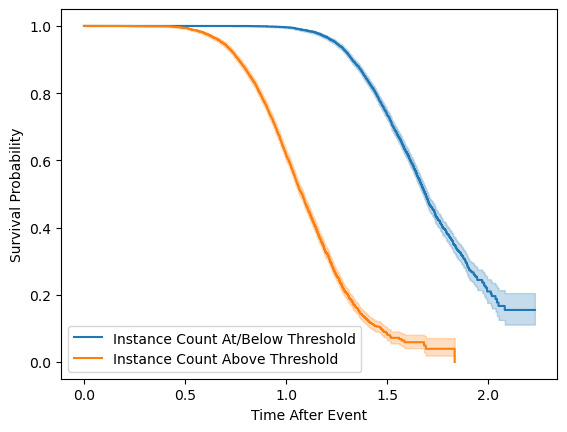

In [6]:
kmf1 = KaplanMeierFitter()

# fit the model for 1st cohort
kmf1.fit(low_outcome, low_censor, label='Instance Count At/Below Threshold')
a1 = kmf1.plot_survival_function()
a1.set_ylabel('Survival Probability')

# fit the model for 2nd cohort
kmf1.fit(high_outcome, high_censor, label='Instance Count Above Threshold')
kmf1.plot_survival_function(ax=a1)
a1.set_xlabel('Time After Event')

plt.show()

### Check and View Top Bin Ties

In [7]:
top_bin_list = fibers.get_top_bins()
count = len(top_bin_list)
if count > 1:
    print(str(len(top_bin_list))+" bins were tied for best fitness")
    for bin in top_bin_list:
        #print("Features in Bin: "+str(bin.feature_list))
        report = bin.bin_short_report()
        print(report)
else:
    print("Only one top performing bin found")


14 bins were tied for best fitness
                                                     0
Features in Bin:  [P_1, P_10, P_2, P_3, P_5, P_7, P_8]
Threshold:                                           0
Fitness:                                   5497.749569
Bin Size:                                            7
Group Ratio:                                       0.5
Birth Iteration:                                    47
                                                     0
Features in Bin:  [P_1, P_10, P_3, P_5, P_6, P_7, P_8]
Threshold:                                           0
Fitness:                                   5497.749569
Bin Size:                                            7
Group Ratio:                                       0.5
Birth Iteration:                                    45
                                                     0
Features in Bin:  [P_1, P_10, P_2, P_3, P_5, P_7, P_9]
Threshold:                                           0
Fitness:                      

## History of Bin Evolution
### Plot: Fitness of top bin each training iteration

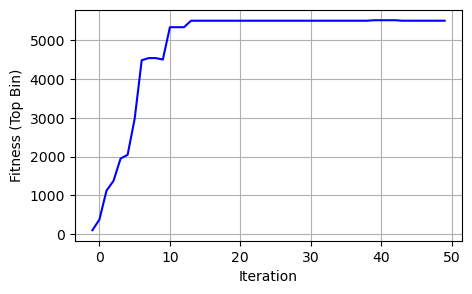

In [8]:
# Extract columns for plotting
time = fibers.top_perform_df['Iteration']
df = fibers.top_perform_df[['Fitness']]

# Plot the data
plt.figure(figsize=(5, 3))
colors = ['blue']  # Manually set colors
for i, column in enumerate(df.columns):
    plt.plot(time, df[column], label=column, color=colors[i])

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Fitness (Top Bin)')
#plt.title('Top Bin Fitness Across Training Iterations')

# Show the plot
plt.grid(True)
plt.show()

### Plot: Normalized Top-Bin Stats Across Training Iterations

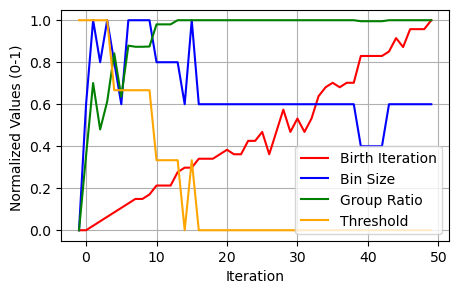

In [9]:
# Extract columns for plotting
time = fibers.top_perform_df['Iteration']
df = fibers.top_perform_df[['Birth Iteration','Bin Size','Group Ratio','Threshold']]
df = (df - df.min()) / (df.max() - df.min())
# Plot the data
plt.figure(figsize=(5, 3))
colors = ['red', 'blue', 'green', 'orange']   # Manually set colors
for i, column in enumerate(df.columns):
    plt.plot(time, df[column], label=column, color=colors[i])

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Normalized Values (0-1) ')
#plt.title('Normalized Top-Bin Stats Across Training Iterations')
plt.legend()  # Show legend

# Show the plot
plt.grid(True)
plt.show()

### View: The dataframe containing all top-bin statistics/characteristics across training iterations

In [10]:
fibers.top_perform_df

,Iteration,Top Bin,Threshold,Fitness,Metric,p-value,Bin Size,Group Ratio,Count At/Below Threshold,Count Below Threshold,Birth Iteration,Residuals Score,Residuals p-value,Elapsed Time
0,-1,"[R_72, P_9, R_53, R_67]",3,105.026111,210.047222,1.341416e-47,4,0.0175,9825,175,0,None,None,5.006262
1,0,"[P_3, P_7, P_9, R_53, R_63, R_72, R_78]",3,380.799012,761.560284,1.229717e-167,7,0.1887,8113,1887,0,None,None,9.977210
2,1,"[P_3, P_7, P_8, P_9, R_14, R_53, R_63, R_67, R...",3,1122.737930,1122.708297,3.831877e-246,9,0.3556,6444,3556,1,None,None,11.281442
3,2,"[P_3, P_7, P_8, P_9, R_21, R_53, R_63, R_75]",3,1377.313780,1377.291135,1.807767e-301,8,0.2491,7509,2491,2,None,None,12.649080
4,3,"[P_3, P_7, P_8, P_9, R_21, R_53, R_63, R_75, P_1]",3,1949.674658,1949.648558,0.000000e+00,9,0.3132,6868,3132,3,None,None,13.965263
5,4,"[P_1, P_3, P_7, P_8, P_9, R_21, R_53, R_63]",2,2046.224451,2046.182061,0.000000e+00,8,0.4239,5761,4239,4,None,None,15.255667
6,5,"[P_1, P_3, P_7, P_8, P_9, R_53, R_63]",2,2971.353661,2971.317661,0.000000e+00,7,0.3240,6760,3240,5,None,None,16.599308
7,6,"[P_1, P_3, P_5, P_7, P_8, P_9, R_53, R_63, P_4]",2,4480.130097,4480.089951,0.000000e+00,9,0.4416,5584,4416,6,None,None,17.929244
8,7,"[P_1, P_3, P_4, P_5, P_7, P_8, P_9, R_21, R_63]",2,4535.794636,4535.754727,0.000000e+00,9,0.4390,5610,4390,7,None,None,19.225191
9,8,"[P_1, P_3, P_4, P_5, P_7, P_8, P_9, R_21, R_63]",2,4535.794636,4535.754727,0.000000e+00,9,0.4390,5610,4390,7,None,None,20.521486


### Examine Feature Tracking Scores

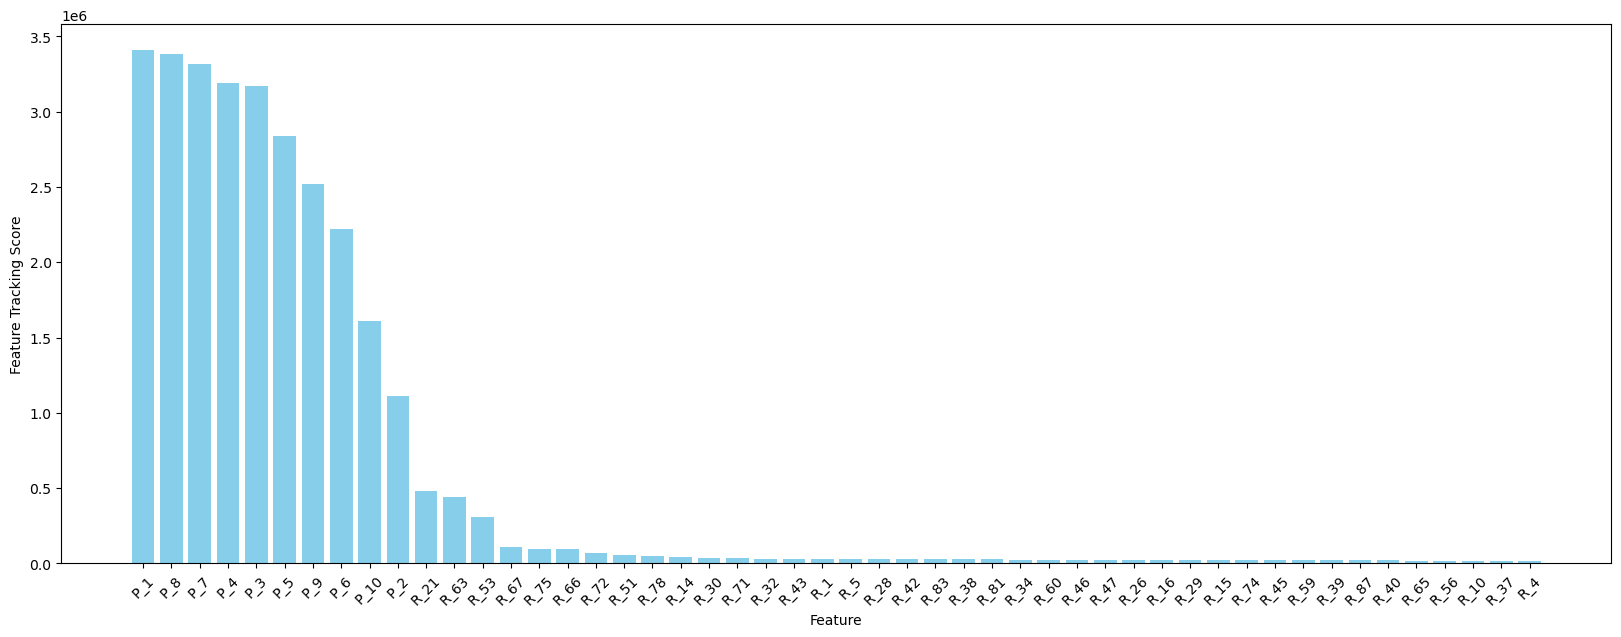

In [22]:
# Get feature names and tracking scores
feature_names, feature_tracking = fibers.get_feature_tracking()

# Filter the top scoring features for visualization
feature_count = 50
# Sort the names and scores based on scores
sorted_pairs = sorted(zip(feature_tracking, feature_names), reverse=True)

# Select the top 3 name/score pairs
top_scores = sorted_pairs[:feature_count]

# Unzip the top 3 pairs
top_scores, top_names = zip(*top_scores )

# Create a bar plot
plt.figure(figsize=(20, 7))
plt.bar(top_names, top_scores, color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Feature Tracking Score')
plt.xticks(rotation=45)
plt.show()

## Transforming Bins Into New Features (Feature Learning)

In [11]:
tdf = fibers.transform(data)
tdf

,Bin_0,Bin_1,Bin_2,Bin_3,Bin_4,Bin_5,Bin_6,Bin_7,Bin_8,Bin_9,...,Bin_42,Bin_43,Bin_44,Bin_45,Bin_46,Bin_47,Bin_48,Bin_49,Duration,Censoring
0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,1,1,0,0,1,1.828137,0
1,3,4,2,1,2,3,2,3,2,3,...,3,3,4,3,3,4,4,2,1.025382,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,0,1.295743,0
3,3,3,3,3,4,4,2,3,3,3,...,4,4,5,4,3,2,4,2,1.186180,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,1,0,1.452234,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1.234257,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,2,1,0,1.819680,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,1,1,1.479425,0
9998,2,2,2,2,3,3,3,3,4,3,...,2,3,4,4,5,3,4,5,1.058906,0


## Prediction (of Strata)
### Predict Strata (Low vs. High) Using Top Bin

In [12]:
predictions = fibers.predict(data,bin_number=0)
print(classification_report(predictions, true_risk_group))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5000
           1       1.00      1.00      1.00      5000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



### Predict Strata (Low vs. High) Using Whole Bin Population (Weighted Voting Scheme)

In [13]:
predictions = fibers.predict(data)
print(classification_report(predictions, true_risk_group))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5000
           1       1.00      1.00      1.00      5000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



## Pareto Front Visualization

In [14]:
def generate_pareto_plot(objective_values_array, titleNum):
    mask = paretoset(objective_values_array, sense=["max", "min"])
    efficient_solutions = sorted([objective_values_array[i] for i in range(len(objective_values_array)) if mask[i]],
                                 key=lambda x: x[0])

    #plt.figure()
    plt.plot([rule[0] for rule in objective_values_array], [rule[1] for rule in objective_values_array],
             "go", markersize=6, label='Non Pareto-optimal')
    plt.plot([rule[0] for rule in efficient_solutions],
             [rule[1] for rule in efficient_solutions],
             "-o", markersize=6, label='Pareto-optimal')

    plt.xlabel('LogRank', fontsize=16)
    plt.ylabel('Bin Simplicity', fontsize=16)

    simplicity_array = [rule[1] for rule in objective_values_array]

    plt.xlim(0, 3000)
    plt.ylim(max(max(simplicity_array) * 2, 10), 0)

    plt.title("Population at Generation " + str(titleNum + 1))

    _ = plt.legend(loc=3, numpoints=1)
    plt.show()

In [15]:
pop_df = fibers.set.get_pop()
print(isinstance(pop_df, pd.DataFrame))
pop_df
pop_df.to_csv('FIBERS_pop.csv', index=False)

True


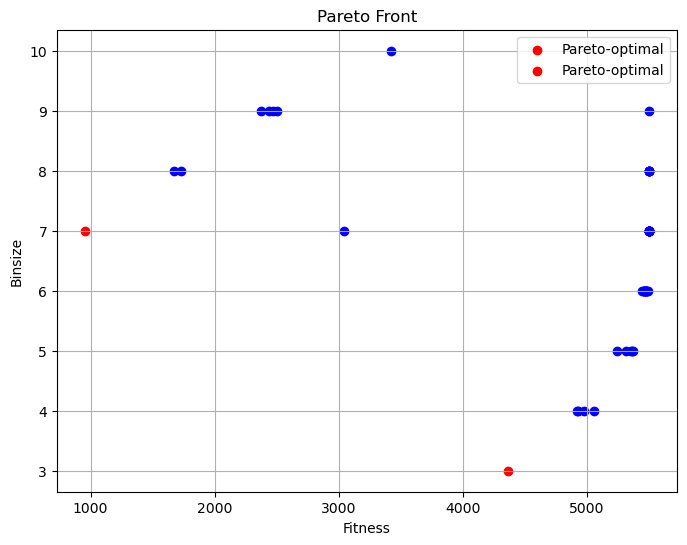

In [16]:

bin_pop = fibers.set.bin_pop
# Initialize lists to store Pareto-optimal solutions
pareto_fitness = []
pareto_binsize = []

# Plot the data
plt.figure(figsize=(8, 6))
for bin in bin_pop:
    fitness = bin.fitness
    binsize = bin.bin_size
    dominated = False
    
    for other_bin in bin_pop:
        if (other_bin.fitness < fitness and other_bin.bin_size < binsize) \
            or (other_bin.fitness <= fitness and other_bin.bin_size < binsize) \
            or (other_bin.fitness < fitness and other_bin.bin_size <= binsize):
            dominated = True
            break
            
    if not dominated:
        pareto_fitness.append(fitness)
        pareto_binsize.append(binsize)
        plt.scatter(fitness, binsize, color='red', label='Pareto-optimal')
    else:
        plt.scatter(fitness, binsize, color='blue')

# Add labels and title
plt.xlabel('Fitness')
plt.ylabel('Binsize')
plt.title('Pareto Front')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [17]:
pop_df = fibers.set.report_pop()

print(pop_df)
max_bin_size = pop_df['Bin Size:'].max()
print(max_bin_size)
object_list = pop_df[['Fitness','Bin Size']]

bin_pop = fibers.set.bin_pop
# Initialize lists to store Pareto-optimal solutions
pareto_fitness = []
pareto_binsize = []

# Sort objects based on fitness (to be maximized) and binsize (to be minimized)
sorted_objects = sorted(object_list, key=lambda x: (x['fitness'], -x['binsize']))

# Initialize lists to store Pareto-optimal solutions
pareto_fitness = []
pareto_binsize = []

# Plot the data
plt.figure(figsize=(8, 6))
for i, obj in enumerate(sorted_objects):
    fitness = obj['fitness']
    binsize = obj['binsize']
    dominated = False
    
    for other_obj in sorted_objects[i + 1:]:
        if other_obj['fitness'] > fitness and other_obj['binsize'] < binsize:
            dominated = True
            break
            
    if not dominated:
        pareto_fitness.append(fitness)
        pareto_binsize.append(binsize)
        plt.scatter(fitness, binsize, color='red', label='Pareto-optimal')
    else:
        break

# Draw a line representing the non-dominated front
plt.plot(pareto_fitness, pareto_binsize, color='green', linestyle='-', linewidth=2, label='Non-dominated front')

# Add labels and title
plt.xlabel('Fitness (Maximize)')
plt.ylabel('Binsize (Minimize)')
plt.title('Pareto Front')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

                                         feature_list  group_threshold  \
0                [P_1, P_10, P_2, P_3, P_5, P_7, P_8]                0   
1                [P_1, P_10, P_3, P_5, P_6, P_7, P_8]                0   
2                [P_1, P_10, P_2, P_3, P_5, P_7, P_9]                0   
3                [P_1, P_10, P_2, P_3, P_4, P_7, P_9]                0   
4                [P_1, P_10, P_2, P_3, P_4, P_5, P_7]                0   
5                 [P_1, P_3, P_4, P_5, P_6, P_7, P_9]                0   
6                [P_10, P_2, P_3, P_5, P_6, P_7, P_9]                0   
7                 [P_1, P_2, P_3, P_4, P_6, P_7, P_8]                0   
8                [P_10, P_2, P_3, P_4, P_5, P_6, P_7]                0   
9                [P_10, P_3, P_4, P_5, P_6, P_7, P_8]                0   
10                [P_1, P_2, P_3, P_4, P_5, P_7, P_9]                0   
11               [P_1, P_10, P_4, P_6, P_7, P_8, P_9]                0   
12               [P_1, P_10, P_3, P_4,

TypeError: 'NoneType' object is not subscriptable